In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pylab  as plt
import os
import nibabel as nib
import numpy as np
import scipy.ndimage as ndimage
from skimage.morphology import  erosion, ball
from scipy.spatial import distance
import random

In [3]:
from brain_segmentation_functions import  mst_construction, BFS_path, split_components, graph_ingredients
from preprocessing_functions import remove_small_objects, padding, unpadding,  opening_parts
from Edge_surface_detect_fnc import separate_head_scan, identify_points 
from sampling_points_fnc import randomize_nodes, sampling_points_within_brain, sampling_points_within_nonbrain
from sampling_points_fnc import sampling_points_within_background
from segmentation_labels import expand_labels, remove_sobj

In [4]:
# This cell loads the 3d mri images converted, reshaped to the same shape, scaled and saved in the .npy format
# For  3d MRI
file_path = '..load img_test1.npy'
files  =  os.listdir(file_path)
files_mri  = [file for file in files if  file.endswith('.npy')]
files_mri = sorted(files_mri)
volume_mri  = [file_path + '/' + file for file in files_mri]

# For ground truth
file_path_gt = '..load mask_test1.npy'
files  =  os.listdir(file_path_gt)
files_gt  = [file for file in files if  file.endswith('.npy')]
files_gt = sorted(files_gt)
volume_gt  = [file_path_gt + '/' + file for file in files_gt]

In [5]:
i = 0

In [6]:
# loading the .npy files which have been reshaped, resize and scaled
test_img = np.load(volume_mri[i])
# extract the volume because the saved files shape is ((128, 128, 128, 1))
# test_img_mod = test_img[:,:,:, 0]
# test_img_mod[:,:,125:] =0
# padding zeros around the brain 3d MRI by the thickness.  It is not explained in the paper
#  b'se it is not important. We just want to make sure that the background is wide enough
alpha = 12
img_mod = padding(test_img, alpha)
# loading the ground truth
test_mask = np.load(volume_gt[i])

In [7]:
# removing possible small objects outside the head (explained in the preprocessing subsection)
radius = 11 # this is the radius for the structuring element
img_mod, binarized_bin1 = remove_small_objects(img_mod, radius)

In [8]:
# closing the possible holes (explained in the preprocessing subsection)
BINARY = ndimage.binary_closing(binarized_bin1, structure=np.ones((13,13,13))).astype(int)

In [9]:
# The selection_line parameter is expalined in the sampling points section (we apply it 
# before the sampling points step to ease the implimentation)
selection_line = 55
BINARY_top, BINARY_lower  = separate_head_scan(BINARY, selection_line)

Edge surface detection points

In [10]:
# alpha parameter is for padding and undpadding zero values.
delta = 6; alpha = 0 
ptsxe, ptsye, ptsze, template, _ = identify_points(BINARY_top, img_mod, delta, alpha)

In [11]:
# delta parameter in the previous step is used for pulling points where we want to open some part in the head
recons_image = opening_parts(img_mod, BINARY_top, BINARY_lower, ptsxe, ptsye, ptsze)
# this step is not important for BrainWeb data. Uncomment to line below to use brainWeb
# recons_image = img_mod.copy()

Sampling points within the brain

In [12]:
# Note that alpha is for padding and unpadding
# delta1 is explained in the in the paper in sampling point subsection
delta1 = 15; alpha = 6
ptsx, ptsy, ptsz, template, _ = identify_points(BINARY_top, img_mod, delta1, alpha)

In [13]:
nodes_within_brain = sampling_points_within_brain(ptsx, ptsy, ptsz, template)

Sampling points within the nonbrain tissues

In [14]:
# Note that alpha is for padding and unpadding
# delta2 is explained in the in the paper in sampling point subsection
delta2 = 1; alpha = 6
ptsx_out, ptsy_out, ptsz_out, template,_ = identify_points(BINARY_top, img_mod, delta2, alpha)

In [15]:
# the template holds the enumeratin of the nodes
nodes_within_skull = sampling_points_within_nonbrain(ptsx_out, ptsy_out, ptsz_out, template, recons_image)

Sampling points within the background

In [16]:
#  Also we want to prepare the ingredients for construction the graph and MST
alpha = 6
image    = unpadding(recons_image,alpha)
# the template holds the enumeratin of the nodes
template = np.arange(np.prod(image.shape), dtype=np.int).reshape(image.shape)

In [17]:
image.shape, template.shape

((134, 134, 134), (134, 134, 134))

In [18]:
nodes_out_head = sampling_points_within_background(BINARY, alpha, template)

In [19]:
brain_nodes, skull_nodes, out_skull_nodes = randomize_nodes(nodes_within_brain, nodes_within_skull, nodes_out_head)

MST Construction

In [20]:
cols, rows, costs = graph_ingredients(image, brain_nodes, skull_nodes, out_skull_nodes)

In [21]:
mst = mst_construction(cols, rows, costs, image)

Splitting the connected components

In [22]:
new_labels = split_components(mst, brain_nodes[0], skull_nodes[0])
new_labels = split_components(mst, skull_nodes[0], out_skull_nodes[0])

Reshape the labels back to the shape of the image

In [23]:
new_labels_reshaped = new_labels.reshape(image.shape)

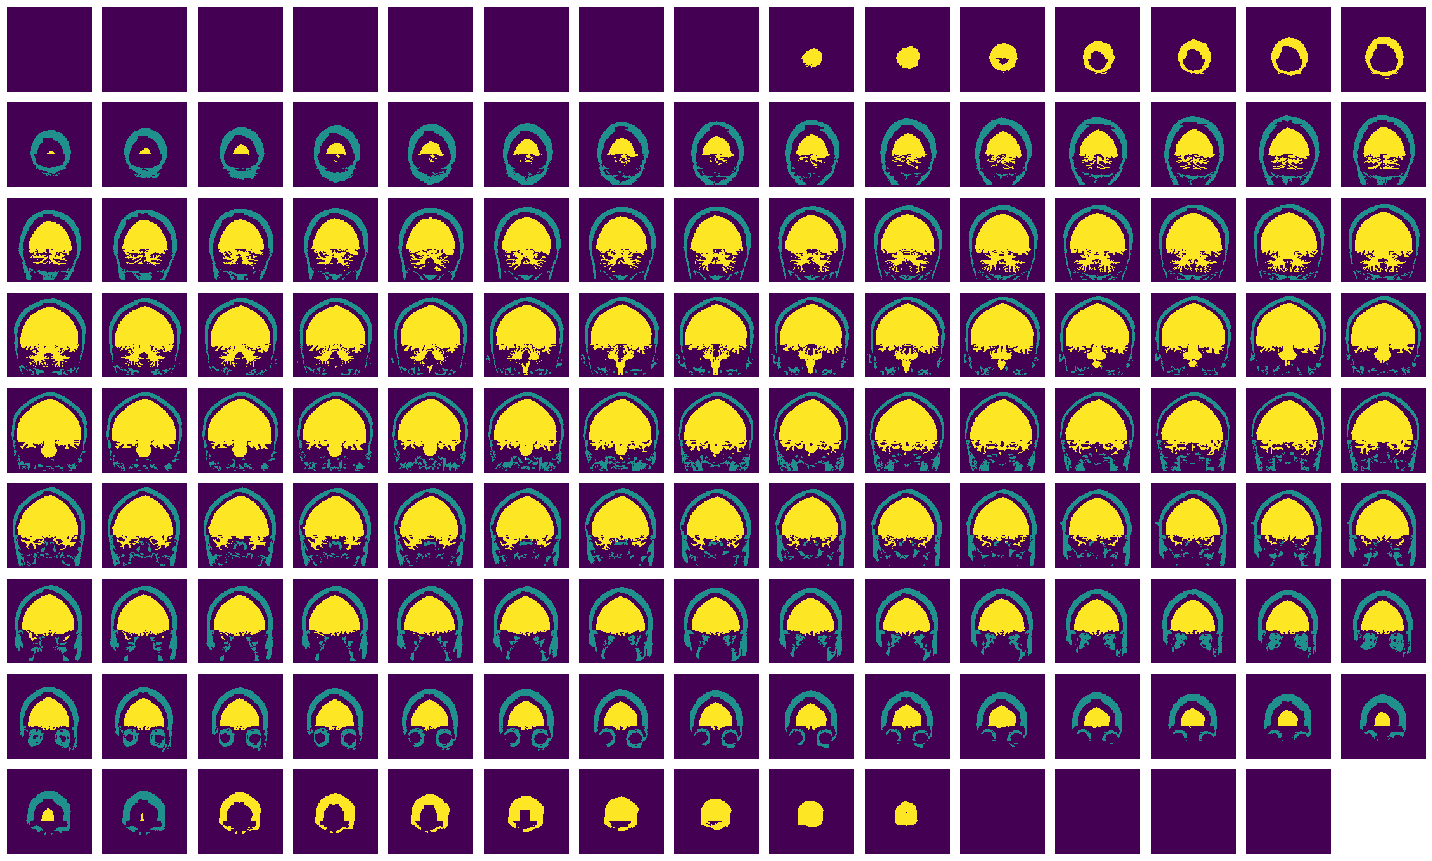

In [24]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.3, wspace = 0.1)
for i in range(image.shape[2]):
    skeleton = ndimage.rotate(new_labels_reshaped[:,i,:],90)
    ax = fig.add_subplot(15,15, i+1)   
    ax.imshow(skeleton)
#     plt.title('Slice %s ' %s )
    ax.set_axis_off()
    fig.set_size_inches(20, 20)
plt.tight_layout()

In [25]:
new_labels_reshaped.shape

(134, 134, 134)

Post-processing and using the labels for segmentation

In [26]:
# Get label representative
label1 = new_labels_reshaped[template == skull_nodes[0]][0]
label2 = new_labels_reshaped[template == brain_nodes[0]][0]
label3 = new_labels_reshaped[template == out_skull_nodes[0]][0]

In [27]:
temp_mask = new_labels_reshaped.copy()
temp_mask[temp_mask!=label2]=0
# For brainweb data some stepS dont add any value, they can be skipped to (F) running them is not a problem

In [28]:
B1 = remove_sobj(temp_mask, 2)

In [29]:
skull = new_labels_reshaped.copy()
skull[skull==label2]=0
post_proslabels = skull + B1
templabels = expand_labels(post_proslabels,5)

In [30]:
templabels.shape

(134, 134, 134)

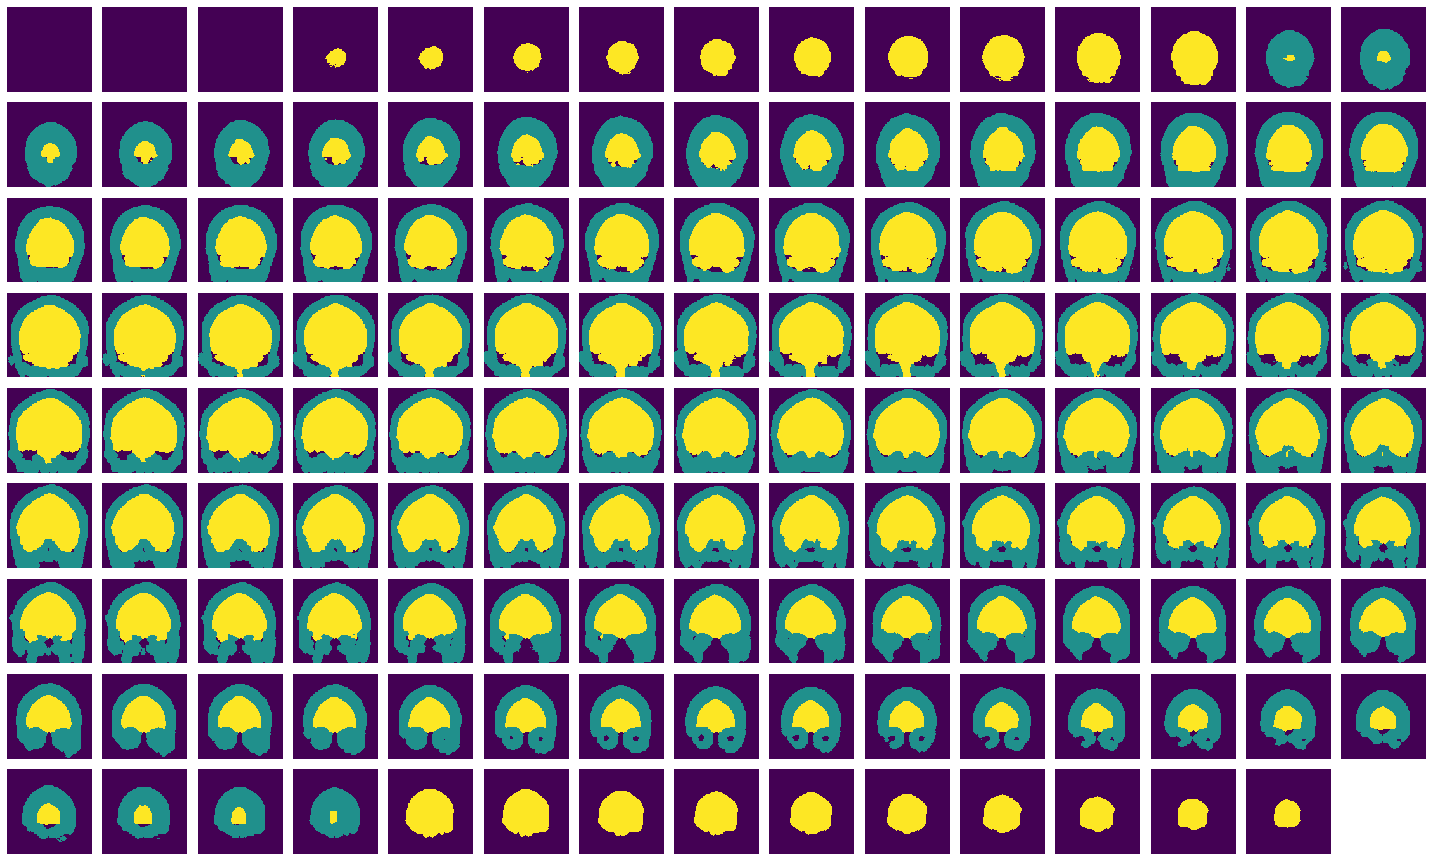

In [31]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.3, wspace = 0.1)
for i in range(B1.shape[2]):
    skeleton = ndimage.rotate(templabels[:,i,:], 90)
    ax = fig.add_subplot(15,15, i+1)   
    ax.imshow(skeleton)
#     plt.title('Slice %s ' %s )
    ax.set_axis_off()
    fig.set_size_inches(20, 20)
plt.tight_layout()

(F) Use the predicted labels to segment the brain

In [32]:
# Remember that before construction the graph we only unpadded by 6. We unppad by 6 to get back the size of 
# the loaded image of the label obtained
A1 = unpadding(templabels,6)
# take the padded original image, unpadd by 12, then use the labels A1 to segment the brain
given_mri = img_mod.copy()
alpha = 12
mri_image = unpadding(given_mri, alpha)
mri_image[A1!=label2] =0

In [33]:
np.max(test_img)

1.0

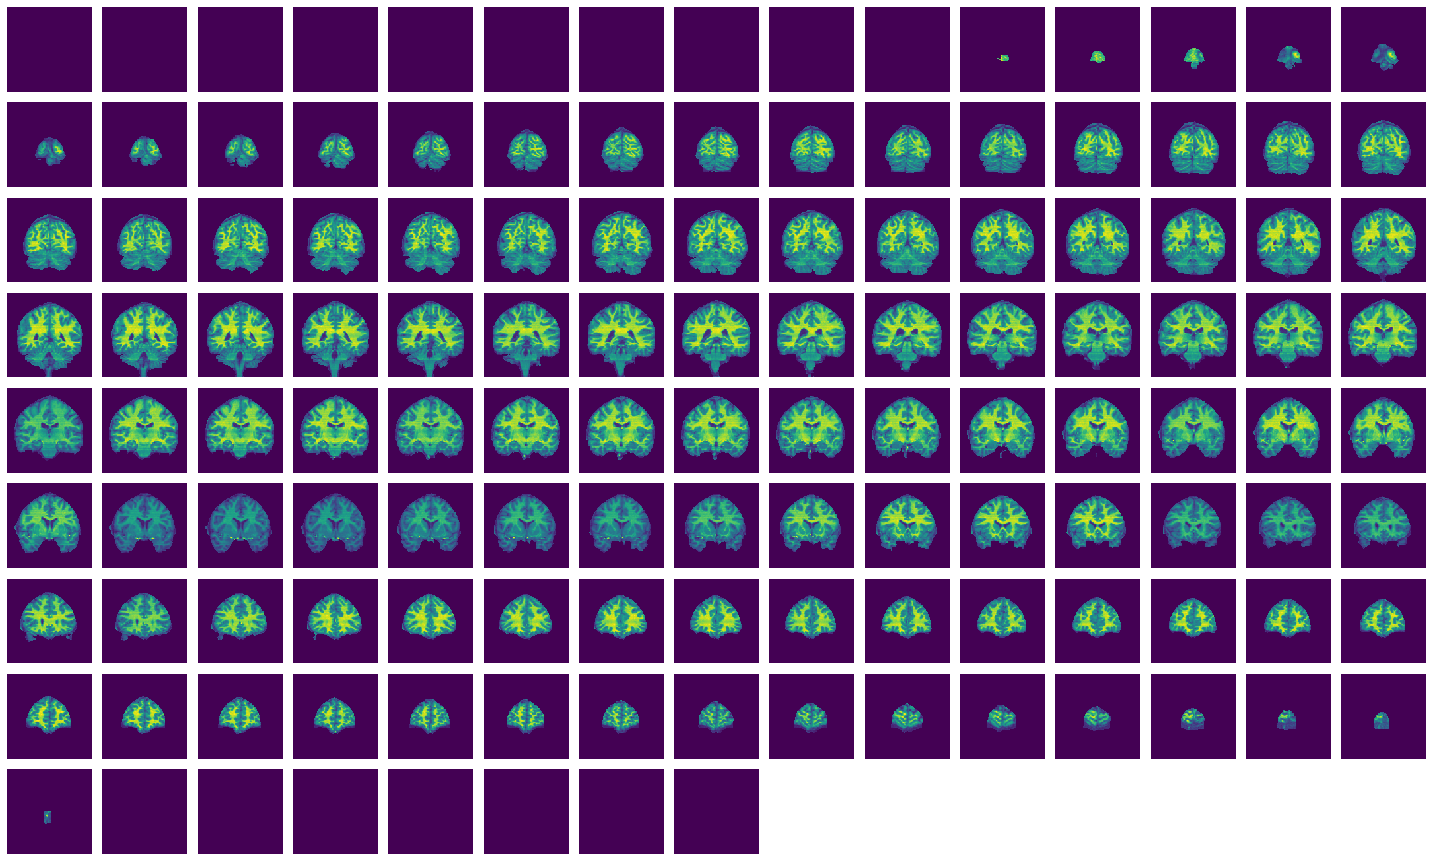

In [34]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.3, wspace = 0.1)
for i in range(mri_image.shape[2]):
    skeleton = ndimage.rotate(mri_image[:,i,:],90)
    ax = fig.add_subplot(15,15, i+1)   
    ax.imshow(skeleton)
    plt.xticks(np.linspace(0, np.max(test_img)))
    plt.yticks(np.linspace(0, np.max(test_img)))
#     plt.title('Slice %s ' %s )
    ax.set_axis_off()
    fig.set_size_inches(20, 20)
plt.tight_layout()

In [35]:
mri_image.shape

(128, 128, 128)

Use the ground truth mask to segment the brain for comparison

In [36]:
# note that loaded image were padded with thickness of 12 and not the ground truth
#  we unpadd by 12 thickness  and then apply the mask to get the ground truth
given_mri = img_mod.copy()
mri_image = unpadding(given_mri, 12) # get the original size when it was loaded
mri_image[test_mask==0]=0

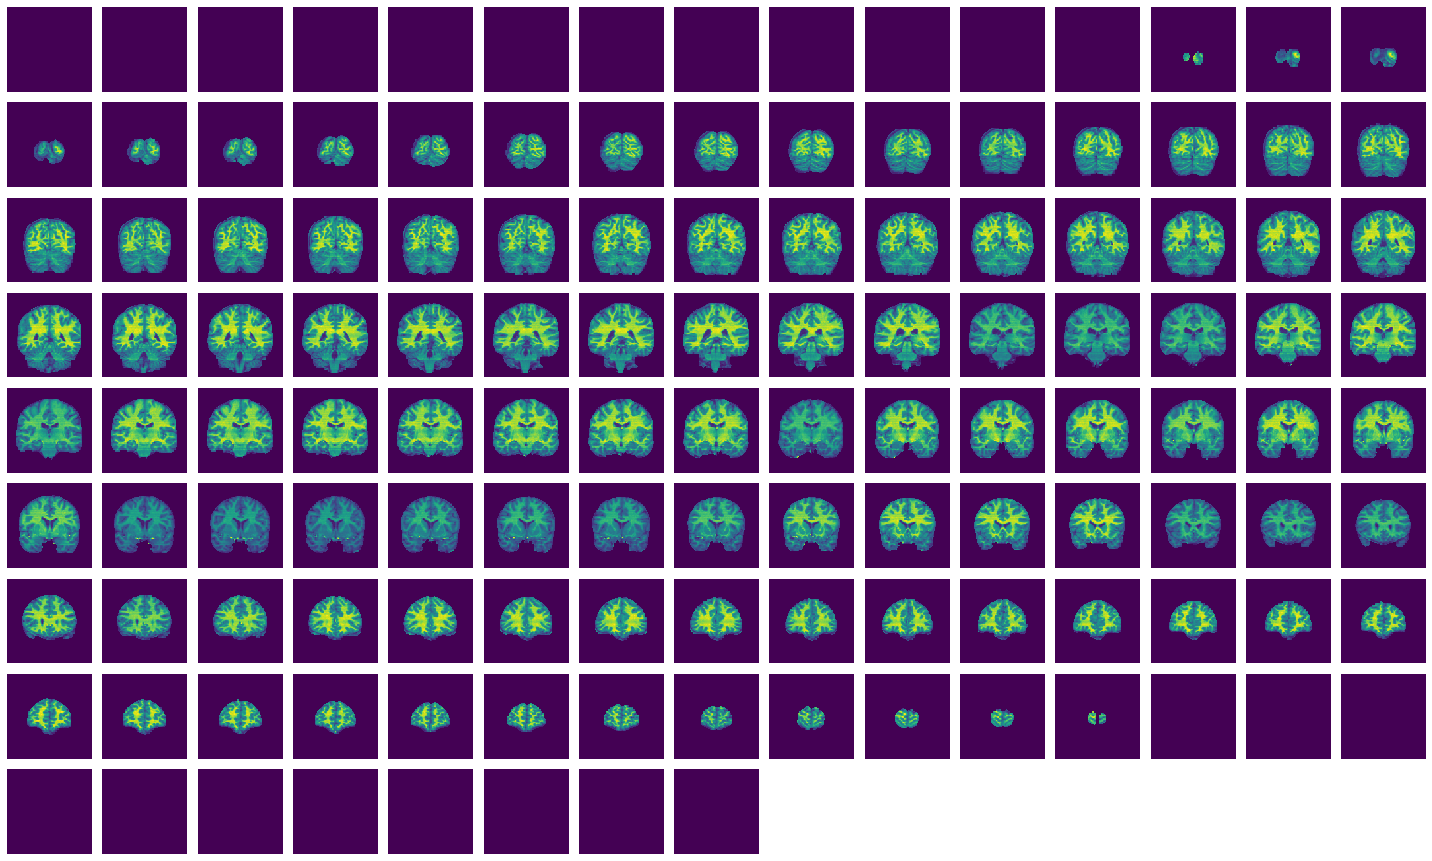

In [38]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.3, wspace = 0.1)
for i in range(mri_image.shape[2]):
    skeleton = ndimage.rotate(mri_image[:,i,:],90)
    ax = fig.add_subplot(15,15, i+1)   
    ax.imshow(skeleton)
    plt.xticks(np.linspace(0, np.max(test_img)))
    plt.yticks(np.linspace(0, np.max(test_img)))
#     plt.title('Slice %s ' %s )
    ax.set_axis_off()
    fig.set_size_inches(20, 20)
plt.tight_layout()